In [256]:
# plots
%matplotlib inline

import matplotlib.pyplot as plt
from pylab import rcParams
import math
rcParams['figure.figsize'] = 15, 8

import math
import scipy


# Pandas
import pandas as pd
from pandas import DataFrame

# math api
import numpy as np

# time lib
import time
import datetime as dt

NOW = dt.datetime.now()


import seaborn as sns
sns.set()


# excel reader
import xlrd 

In [201]:
flat_data = pd.read_excel("../ressources/data/input_aerospace_proof_of_concept.xlsx")
flat_data = flat_data.fillna(0).replace('-', np.NaN)
flat_data.head()

,COMPANY_NAME,TICKER_COMPANY,INDUSTRY_CLASSIFICATION,COUNTRY,S_and_P_rating,Parent Company,Ultimate Corporate Parent,FINANCIAL_INFO_YEAR,FULL_YEAR_REVENU,EBIT_FULL_YEAR,EBITDA_FULL_YEAR,CAPEX,TOTAL_ASSETS,NET_PROPERTY_PLANT_EQUIPEMENT_FY,MACHINERY,TOTAL_CAPITAL_LEASES
0,Entreprise 1,TICKER 1,Aerospace and Defense (Primary),Netherlands (Primary),A+,NaN,AirWarrior SE (ENXTPA:AIR),2018,681.575720,274.589114,969.822435,313.092117,4.727786,87.653349,839.586144,689.557183
1,Entreprise 2,TICKER 2,Aerospace and Defense (Primary),France (Primary),B+,NaN,Moult-Entreprise SA (ENXTPA:SAF),2018,766.251596,548.181420,758.380229,954.220082,677.921496,462.919617,812.268342,658.189895
2,Entreprise 3,TICKER 3,Aerospace and Defense (Primary),Netherlands (Primary),A+,NaN,AirWarrior SE (ENXTPA:AIR),2018,312.685631,121.764303,937.873075,132.622301,23.724888,496.675377,34.307213,56.821466
3,Entreprise 4,TICKER 4,Aerospace and Defense (Primary),France (Primary),B+,NaN,Moult-Entreprise SA (ENXTPA:SAF),2018,679.203287,771.564252,182.324284,839.823809,839.276942,844.497664,270.434188,591.540389
4,Entreprise 5,TICKER 5,Aerospace and Defense (Primary),Netherlands (Primary),A+,NaN,AirWarrior SE (ENXTPA:AIR),2018,110.835298,858.722310,922.709546,708.459216,685.349190,794.669451,961.526554,923.936854


In [202]:
weights = {
    'RATIO_CAPEX_REVENU': 0.025,
    'RATIO_PPE_ASSETS': 0.35,
    'RATIO_MACHINERY_PPE': 0.075,
    'RATIO_DEPRECIATION_REVNEUS': 0.075,
    'RATIO_DEPRECIATION_PPE': 0.025,
    
    'RATIO_CAPITAL_LEASE_PPE': 0.075,
    'RATIO_ROA': 0.35,
    'RATIO_FA_TURNOVER': 0.025,
}

reversed_proba = {
    'RATIO_CAPEX_REVENU': False,
    'RATIO_PPE_ASSETS': False,
    'RATIO_MACHINERY_PPE': False,
    'RATIO_DEPRECIATION_REVNEUS': False,
    'RATIO_DEPRECIATION_PPE': False,
    
    'RATIO_CAPITAL_LEASE_PPE': True,
    'RATIO_ROA': True,
    'RATIO_FA_TURNOVER': True,
}

linearity = {
    'RATIO_CAPEX_REVENU': False,
    'RATIO_PPE_ASSETS': False,
    'RATIO_MACHINERY_PPE': False,
    'RATIO_DEPRECIATION_REVNEUS': False,
    'RATIO_DEPRECIATION_PPE': False,
    
    'RATIO_CAPITAL_LEASE_PPE': False,
    'RATIO_ROA': True,
    'RATIO_FA_TURNOVER': False,
}

flat_data['RATIO_CAPEX_REVENU'] = flat_data['CAPEX'] / flat_data['FULL_YEAR_REVENU']
flat_data['RATIO_PPE_ASSETS'] = flat_data['NET_PROPERTY_PLANT_EQUIPEMENT_FY'] / flat_data['TOTAL_ASSETS']
flat_data['RATIO_MACHINERY_PPE'] = flat_data['MACHINERY'] / flat_data['NET_PROPERTY_PLANT_EQUIPEMENT_FY']
flat_data['RATIO_DEPRECIATION_REVNEUS'] = (flat_data['CAPEX'] - flat_data['EBITDA_FULL_YEAR'] + flat_data['EBIT_FULL_YEAR']) / flat_data['FULL_YEAR_REVENU']
flat_data['RATIO_DEPRECIATION_PPE'] = (flat_data['CAPEX'] - flat_data['EBITDA_FULL_YEAR'] + flat_data['EBIT_FULL_YEAR']) / flat_data['NET_PROPERTY_PLANT_EQUIPEMENT_FY']

flat_data['RATIO_CAPITAL_LEASE_PPE'] = flat_data['TOTAL_CAPITAL_LEASES'] / flat_data['NET_PROPERTY_PLANT_EQUIPEMENT_FY']
flat_data['RATIO_ROA'] = flat_data['EBIT_FULL_YEAR'] / flat_data['TOTAL_ASSETS']
flat_data['RATIO_FA_TURNOVER'] = flat_data['TOTAL_CAPITAL_LEASES'] / flat_data['NET_PROPERTY_PLANT_EQUIPEMENT_FY']

 

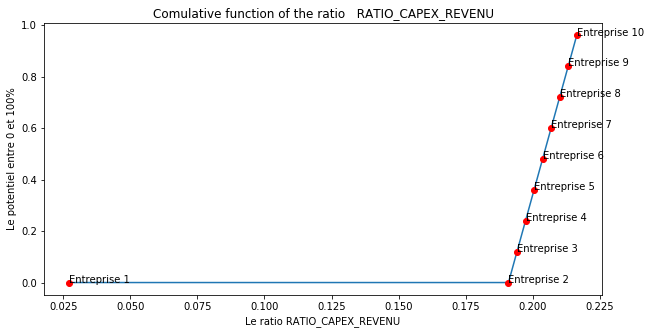

In [203]:
def calculate_density_function_linear(_df, _column_name, _reverse=False):
    # extract column from data
    column_ratio = _df[_column_name]
    
    # filtred non values
    filtred_array = column_ratio.replace([np.inf, -np.inf], np.nan)
    filtred_array = filtred_array[~np.isnan(filtred_array)]
    
    # detect outlier data
    filtred_quantile = filtred_array.quantile([0.05, 0.5, 0.995])
    
    # remove outlier data
    filtred_outlier_array = filtred_array[ filtred_array < filtred_quantile[0.995] ]
    filtred_outlier_array = filtred_outlier_array[ filtred_outlier_array > filtred_quantile[0.05] ]
    
    x_data = None
    y_epoch = None
    
    if  not _reverse :
        x_data = np.linspace( filtred_outlier_array.min(), filtred_outlier_array.max(), 10000 )
        x_data = np.append(filtred_array.min(), x_data)
        x_data = np.append(x_data, filtred_array.max())
        
    else:
        x_data = np.linspace( filtred_outlier_array.max() , filtred_outlier_array.min(), 10000 )
        x_data = np.append(filtred_array.max(), x_data)
        x_data = np.append(x_data, filtred_array.min())
        
         
    y_epoch = np.linspace(0, 1, len(x_data) -2)
    y_epoch = np.append(0, y_epoch)
    y_epoch = np.append(y_epoch, 1)
    
    return x_data, y_epoch



def calculate_density_function_log(_df, _column_name, _reverse=False): 
    # extract column from data
    column_ratio = _df[_column_name]
    
    # filtred non values
    filtred_array = column_ratio.replace([np.inf, -np.inf], np.NaN)
    filtred_array = filtred_array[~np.isnan(filtred_array)]
    
    # detect outlier data
    filtred_quantile = filtred_array.quantile([0.05, 0.5, 0.995])
    
    # remove outlier data
    filtred_outlier_array = filtred_array[ filtred_array < filtred_quantile[0.995] ]
    filtred_outlier_array = filtred_outlier_array[ filtred_outlier_array > filtred_quantile[0.05] ]
    
    calculate_perf = lambda x: len(filtred_outlier_array[ filtred_outlier_array < x ]) / filtred_outlier_array.count()
     
    
    
    x_data  = np.linspace( filtred_outlier_array.min(), filtred_outlier_array.max(), 20 )
    x_data = np.append(filtred_array.min(),  x_data)
    x_data = np.append(x_data,  filtred_array.max())
    
    
    if not _reverse: 
        y_epoch = [ calculate_perf(i) for i in x_data ]
    else:
        y_epoch = [ 1 - calculate_perf(i) for i in x_data ]
    
    
    return x_data, y_epoch


def calculate_performance(_df, _column_name, _reverse=False, _linear=False): 
    
    # extract column from data 
    column_ratio = _df[_column_name]
    
    # filtred nan values
    filtred_array = column_ratio.replace([np.inf, -np.inf], np.nan)
    filtred_array = filtred_array[~np.isnan(filtred_array)]
    # detect outlier data
    filtred_quantile = filtred_array.quantile([0.05, 0.5, 0.995])
    
    # remove outlier data
    filtred_outlier_array = filtred_array[ filtred_array <= filtred_quantile[0.995] ]
    filtred_outlier_array = filtred_outlier_array[ filtred_outlier_array >= filtred_quantile[0.05] ] 
    
    
    if _linear:
        x, y = calculate_density_function_linear(_df, _column_name, _reverse )
    else:
        x, y = calculate_density_function_log(_df, _column_name, _reverse )
    
       
    if  not _reverse and not _linear:
        return column_ratio.apply(lambda value: 0 if  math.isnan(value)  else  y[np.where(x <= value)[0].max()]  ) , x, y
    elif not _reverse and  _linear:
        return column_ratio.apply(lambda value: 0 if  math.isnan(value)  else  y[np.where(x <= value)[0].max()]  ) , x, y
    
    if   _reverse and not _linear:
        return column_ratio.apply(lambda value: 0 if  math.isnan(value)  else  y[np.where(x <= value)[0].min()]  ) , x, y
    
    elif  _reverse and  _linear:
        return column_ratio.apply(lambda value: 0 if  math.isnan(value)  else  y[np.where(x <= value)[0].min()]  ) , x, y
    
    
    

    
    
 # test   
_tmp_ratio_name = 'RATIO_CAPEX_REVENU' 
_tmp_reverse = False
_tmp_linear = True

potential, x, y = calculate_performance(flat_data, _tmp_ratio_name , _reverse=_tmp_reverse , _linear=_tmp_linear )

rcParams['figure.figsize'] = 10, 5

plt.plot(x[:10], y[:10]* 1200)
plt.xlabel('Le ratio ' + _tmp_ratio_name)
plt.ylabel('Le potentiel entre 0 et 100%')
plt.title("Comulative function of the ratio   " + _tmp_ratio_name)



for i in range(len(x[0: 10])):
    plt.plot(x[i], y[i] * 1200, 'ro')
    plt.text(x[i], y[i] * 1200, flat_data['COMPANY_NAME'].values[i]) 
    

 









In [209]:
# calculate the potentials
prefix_spliter = 'RATIO_'
potential_prefix = 'POTENTIAL_'
for column_name in filter(lambda x: prefix_spliter in x, flat_data.columns.values):
    new_potential_column = column_name.replace(prefix_spliter, potential_prefix) 
    
    # calculate potential
    _reverse = reversed_proba[column_name] 
    _linear  = linearity[column_name] 
    flat_data[new_potential_column], x, y = calculate_performance(flat_data, column_name,  _linear=_linear, _reverse=_reverse) 
    
    
    flat_data[new_potential_column] *=  weights[column_name]
    
    


# calculate the final potential
flat_data['FINAL_POTENTIAL'] = 0
for column_name in filter(lambda x: potential_prefix in x, flat_data.columns.values):
    flat_data['FINAL_POTENTIAL'] += flat_data[column_name]
    
flat_data['FINAL_POTENTIAL'] *=  100

In [247]:
mean_ppe_asset = flat_data['RATIO_PPE_ASSETS'].mean()
half_mean_ppe_asset = mean_ppe_asset / 2

print('mean : ' , mean_ppe_asset)
print('half mean : ', half_mean_ppe_asset)
print("\n")

interest_rate = 0.00235
machinery = 0.35

beta_1 = 1
beta_2 = 0.3
beta_3 = 0.1

def calculate_leased_capital(x):
    ratio_ppe_asset = x['RATIO_PPE_ASSETS'] 
    
    result_part1 = 0
    result_part2 = 0
    result_part3 = 0
    
    if ratio_ppe_asset > mean_ppe_asset:
        result_part1 = (ratio_ppe_asset - mean_ppe_asset) 
    else:
        result_part1 = 0 
    
     
    
    if ratio_ppe_asset > half_mean_ppe_asset:
        if ratio_ppe_asset > mean_ppe_asset:
            result_part2 =  half_mean_ppe_asset 
        else:
            result_part2 = (ratio_ppe_asset - half_mean_ppe_asset) 
    else:
         result_part2 = 0
     
    
    
    
    if ratio_ppe_asset < half_mean_ppe_asset:
        result_part3 =   ratio_ppe_asset 
    else:
        result_part3 =   half_mean_ppe_asset 
    
     
    
    result_part1 *= beta_1 * machinery * x['TOTAL_ASSETS'] 
    result_part2 *= beta_2 * machinery * x['TOTAL_ASSETS'] 
    result_part3 *= beta_3 * machinery * x['TOTAL_ASSETS'] 
    
    return result_part1 + result_part2 + result_part3

flat_data['FORECAST_NBI'] = flat_data.apply(calculate_leased_capital, axis=1)


# final result 
flat_data['FINAL_RANK'] = flat_data['FINAL_POTENTIAL'] * flat_data['FORECAST_NBI']



mean :  32.16351660108125
half mean :  16.081758300540624




In [253]:
# calculate the quantile
f_x = lambda x: int( 10 + math.log(x+1) )
len_df = len(flat_data)

step = f_x(len_df)

def calculate_label(x):
    if x < step:
        return 'GOLD'
    elif x < 2 * step:
        return 'SILVER'
    elif x < 3 * step:
        return 'BRONZE'
    else:
        return 'NA'

flat_data['FINAL_LABEL'] = flat_data['FINAL_RANK'].rank(ascending=False).apply(calculate_label)

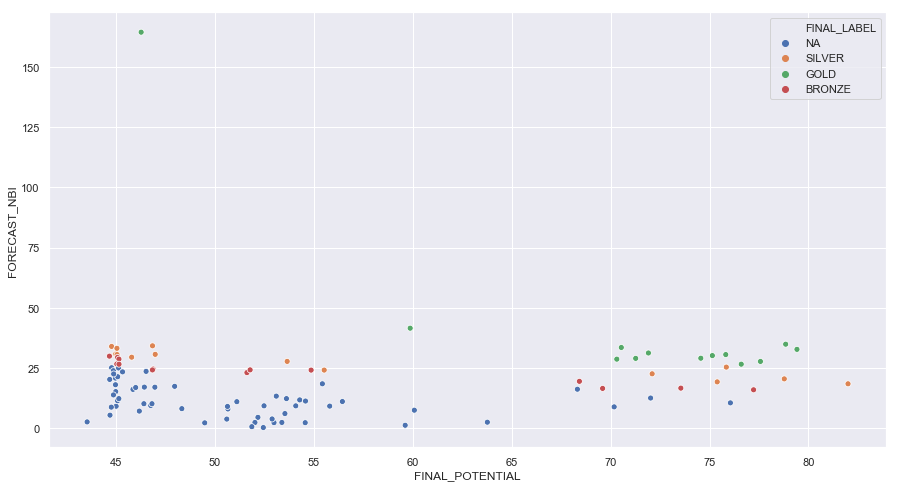

In [260]:
ax = sns.scatterplot(x="FINAL_POTENTIAL", y="FORECAST_NBI",hue="FINAL_LABEL", data=flat_data)